<a href="https://colab.research.google.com/github/RudrenduPaul/AI-Strategies-StockMarket/blob/master/Sandbox/Paul_Sandbox/05_ext_horizon_exp_window_n_current_2_KF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Time Series Forecasting, Extended Horizon, Expanding Window with Real-Time Data

Sources:
* [TensorFlow documentation - Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)
* [Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
* [How to Convert a Time Series to a Supervised Learning Problem in Python](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)
* [Coursera Sequences, Time Series and Prediction by deeplearning.ai](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction)
* [Setting callbacks using tf.keras](https://keras.io/api/callbacks/)

### December updates:
* Vintage data is used rather than the latest vintage
* Virtual vintages were created for all of the months where there is no vintage available
* Features were standardized within a vintage
* For ground truth (GDPC1) final vintage was used throughout. 
* GDPC1 is being scaled by being multiplied by 100 and a division by 100 for evaluation (after model training). This helps with training.
* Data preprocessing steps were updated
* `multivariate_data()` was updated to use date instead of index. The vintage logic was implemented
* `compile_and_fit()` was alos updated to reflect the changes

## V4 updates
* Changing the training date so that there is no overlap between train/test

In [33]:
#  Whether we are in Colab or not?
import sys
is_colab = 'google.colab' in sys.modules

if is_colab:
    from google.colab import auth
    auth.authenticate_user()

In [ ]:
!pip install wandb -q
import wandb
wandb.init(entity           = 'fiscal-forcast',
           project          = "ext-horizon-exp-window",
           save_code        = True
           )

     |████████████████████████████████| 2.0MB 6.0MB/s 
     |████████████████████████████████| 133kB 52.3MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 163kB 51.7MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
history_size_q = 8  # number of quarter lags
history_size_m = 12 # number of month lags
target_size = 5  # How many steps ahead to forecast
n_current_months = 2
lr = 5e-3
EVALUATION_INTERVAL = 9  # steps_per_epoch (number of weight updates)
moving_rmse_n_Qs = 8  # number of quarters to calculate moving rmse
number_of_runs = 20  # Total number of runs

feature_scaling  = True  # Set to true to have features to be scaled within their vintages
save_to_BQ = True  # whether to save the predictions to BQ or not 
save_models = False  # saves the models locally

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import random
import time
import pickle
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from datetime import datetime
from sklearn.model_selection import train_test_split
from google.cloud import bigquery
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'), '(for more info run "watch -n 1 nvidia-smi" from terminal)')

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from matplotlib import gridspec
plt.style.use('ggplot')
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from math import sqrt

# Print all outputs in a code block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import SVG

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not attached to a GPU accelerator.')
else:
    print(gpu_info)

print('Number of CPUs available:', cpu_count())

2.4.1
GPU Available:  [] (for more info run "watch -n 1 nvidia-smi" from terminal)
Not attached to a GPU accelerator.
Number of CPUs available: 4


## Quarterly data
While preparing the quarterly data we will also create the missing vintage months (vm) using the next available vintage

In [ ]:
###################################################
######## DOWNLOAD THE QUARTERLY DATA FROM BQ ######
###################################################
bucket_name = 'imf-temp'
project_id = "imf-bu"
client = bigquery.Client(project_id)
dataset_id = "imf_model_raw_data"
table_id = "fed_q_train_test_vintages_lag_struct_kf"

destination_uri = "gs://{}/{}".format(bucket_name, table_id+".csv")
dataset_ref = bigquery.DatasetReference(project_id, dataset_id)
table_ref = dataset_ref.table(table_id)

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    location="US",
)  # API request
extract_job.result()  # Waits for job to complete.

!gsutil -m cp gs://imf-temp/"$table_id".csv .

df_q = pd.read_csv(table_id+".csv", dtype='str')

Copying gs://imf-temp/fed_q_train_test_vintages_lag_struct_kf.csv...
/ [1/1 files][357.8 MiB/357.8 MiB] 100% Done                                    
Operation completed over 1 objects/357.8 MiB.                                    


In [ ]:
target_variable = 'GDPC1'

df_q = df_q.sort_values(['vintage','sasdate'])
df_q.sasdate = pd.to_datetime(df_q.sasdate).dt.date
df_q.vintage = pd.to_datetime(df_q.vintage).dt.date
df_q.set_index('sasdate', inplace=True)
df_q.index.name = 'date'
new_columns = list(df_q.columns)
new_columns.remove(target_variable)
new_columns.append(target_variable)
df_q = df_q[new_columns]

# ensure all data is float
cols = list(df_q.columns); cols.remove('vintage')
df_q[cols] = df_q[cols].astype('float32')

first_vintage_q = df_q.vintage.min()
last_vintage_q = df_q.vintage.max()
last_vintage_q_df = df_q[df_q.vintage==last_vintage_q]
BEGIN_DATE = last_vintage_q_df.index.min()
last_date_q = last_vintage_q_df.index.max()
MAX_TRAINING_DATE = last_date_q - pd.DateOffset(months= target_size*6 - 6)  # to accomodate with non-overlapping train/test

df_q = df_q[df_q.vintage > BEGIN_DATE+pd.DateOffset(months=3*history_size_q)]  # deleting vintages for the first 2 years
df_q

,vintage,PCECC96,PCDGx,PCESVx,PCNDx,FPIx,Y033RC1Q027SBEAx,PNFIx,PRFIx,A014RE1Q156NBEA,A823RL1Q225SBEA,FGRECPTx,SLCEx,DPIC96,OUTNFB,OUTBS,INDPRO,IPFINAL,IPCONGD,IPMAT,IPDMAT,IPNMAT,IPDCONGD,IPB51110SQ,IPNCONGD,IPBUSEQ,IPB51220SQ,TCU,CUMFNS,PAYEMS,USPRIV,MANEMP,SRVPRD,USGOOD,DMANEMP,NDMANEMP,USCONS,USEHS,USFIRE,USINFO,...,PERMITS,PERMITW,NIKKEI225,NASDAQCOM,TLBSNNCBx,TLBSNNCBBDIx,TTAABSNNCBx,TNWMVBSNNCBx,TNWMVBSNNCBBDIx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S_P_500,S_P__indust,S_P_div_yield,S_P_PE_ratio,GPDIC1,GCEC1,EXPGSC1,IMPGSC1,WPSFD49207,WPSFD49502,WPSFD4111,WPSID61,WPSID62,CUSR0000SAD,CUSR0000SA0L2,HWIURATIOx,CONSPIx,MORTGAGE30US,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,M1REAL,M2REAL,MZMREAL,VXOCLSx,BOGMBASEREALx,TWEXAFEGSMTHx,GDPC1
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1959-09-01,1961-10-01,0.010396,0.017594,0.013414,0.003514,0.010197,0.029981,0.026812,-0.020380,0.1,5.4,-0.024706,0.000912,-0.001383,-0.004952,-0.005132,-0.041763,0.013428,0.011072,-0.109498,-0.184232,0.003681,0.002502,-0.035126,0.013200,0.019659,0.019461,0.000000,80.498764,0.000112,-0.001007,-0.007502,0.004840,-0.008277,-0.017681,0.007035,-0.005299,0.006260,0.007330,-0.004639,...,0.000000,0.000000,0.099539,0.000000,0.007270,9.212139,0.005620,0.009917,0.800000,-0.004712,-24.240000,0.009580,0.021050,0.023641,-0.029166,-0.017545,-0.066761,0.008529,0.031200,0.009346,-0.004012,-0.001001,0.001834,-0.006498,-0.020310,-0.002623,0.005402,-0.0171,0.0041,0.00,0.025554,275597.46875,-0.000151,0.001927,0.008382,0.008503,0.000000,0.005939,0.000000,-0.001928
1959-12-01,1961-10-01,0.001131,-0.048243,0.011552,0.006390,-0.011473,-0.002339,-0.002375,-0.028808,0.8,-3.9,0.003049,-0.005529,0.007134,-0.001586,0.001784,0.004772,-0.011046,-0.010278,0.023521,0.040397,-0.009815,-0.053005,-0.155861,0.005384,-0.021538,0.021140,0.000000,80.075668,0.003748,0.002050,-0.001042,0.007501,-0.002989,-0.001893,0.000157,-0.013536,0.012404,0.007679,-0.000969,...,0.000000,0.000000,0.082004,0.000000,0.033616,9.012266,0.006242,0.000303,-128.750000,-0.000266,-91.430000,0.055552,-0.016596,-0.016630,0.085202,-0.061598,0.032025,-0.008134,-0.027140,-0.025734,-0.002024,-0.005017,-0.001999,0.003244,0.008358,-0.001738,-0.003259,-0.0487,0.0032,0.00,-0.015296,255408.93750,-0.002293,-0.015032,-0.002567,-0.000926,0.000000,-0.000433,0.000000,0.003924
1960-03-01,1961-10-01,0.009478,0.032716,0.009376,0.002170,0.033211,0.035482,0.033788,0.032070,2.1,-14.2,0.086911,0.017884,0.011825,0.029089,0.024437,0.058544,0.036609,0.038197,0.093306,0.146306,0.028134,0.122553,0.298460,0.007642,0.045856,0.005319,0.000000,84.471497,0.012799,0.013378,0.024210,0.010217,0.017442,0.037699,0.004905,-0.015952,0.012481,0.008553,0.014821,...,0.000000,0.000000,0.050798,0.000000,-0.002504,9.364263,0.004583,0.002658,100.720001,0.003866,72.790001,-0.040818,-0.026074,-0.029895,0.227760,-0.057373,0.095790,-0.017045,0.117969,0.037205,0.009064,0.012036,0.024142,-0.002163,0.011951,-0.001731,-0.001081,0.1397,0.0012,0.00,0.037652,279155.40625,0.009183,-0.003566,0.004340,0.005543,0.000000,-0.022620,0.000000,0.022032
1960-06-01,1961-10-01,0.012605,0.020778,0.010928,0.011179,-0.018311,0.014758,0.015115,-0.086435,0.6,0.8,-0.017362,0.022677,0.006256,-0.011836,-0.009404,-0.021937,-0.000001,0.005340,-0.050544,-0.083428,-0.009224,-0.016445,-0.022335,0.013235,-0.009364,0.020594,0.000000,81.318001,0.002368,0.001064,-0.009888,0.007568,-0.007020,-0.016560,-0.000260,0.007676,0.008918,0.007424,-0.002678,...,-0.040410,-0.019418,0.070539,0.000000,0.010231,9.324647,0.004555,0.000142,-33.680000,-0.000339,-24.490000,0.014470,-0.003679,-0.006779,0.087643,-0.024347,-0.097835,0.010728,0.061588,0.007485,0.000972,0.001951,0.003563,-0.001083,0.005451,-0.006092,0.003199,-0.0499,0.0021,0.00,0.018321,280144.93750,0.003057,-0.008087,0.001999,0.001057,0.000000,-0.008321,0.000000,-0.003802
1960-09-01,1961-10-01,-0.004008,-0.007768,-0.001477,-0.006007,-0.021473,-0.041540,-0.017197,-0.030579,0.8,12.8,-0.010921,0.015436,0.001767,-0.002811,0.000980,-0.016580

### Standardize the quarterly data
We will standardize the features based on the values within the vintage. 

We use the target variable from the latest vintage without standardization.

In [ ]:
%%capture test
df_q_stand = df_q.copy()

if feature_scaling:
    for mo in df_q.vintage.unique():
        dataset_values_q = df_q_stand[df_q_stand.vintage==mo].drop('vintage', axis=1).values
        scaler_q = StandardScaler()
        scaler_q.fit(dataset_values_q)
        df_q_stand.loc[df_q_stand.vintage==mo, df_q_stand.columns[1:]] = scaler_q.transform(dataset_values_q)

In [ ]:
df_q_stand.head(3)

,vintage,PCECC96,PCDGx,PCESVx,PCNDx,FPIx,Y033RC1Q027SBEAx,PNFIx,PRFIx,A014RE1Q156NBEA,A823RL1Q225SBEA,FGRECPTx,SLCEx,DPIC96,OUTNFB,OUTBS,INDPRO,IPFINAL,IPCONGD,IPMAT,IPDMAT,IPNMAT,IPDCONGD,IPB51110SQ,IPNCONGD,IPBUSEQ,IPB51220SQ,TCU,CUMFNS,PAYEMS,USPRIV,MANEMP,SRVPRD,USGOOD,DMANEMP,NDMANEMP,USCONS,USEHS,USFIRE,USINFO,...,PERMITS,PERMITW,NIKKEI225,NASDAQCOM,TLBSNNCBx,TLBSNNCBBDIx,TTAABSNNCBx,TNWMVBSNNCBx,TNWMVBSNNCBBDIx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S_P_500,S_P__indust,S_P_div_yield,S_P_PE_ratio,GPDIC1,GCEC1,EXPGSC1,IMPGSC1,WPSFD49207,WPSFD49502,WPSFD4111,WPSID61,WPSID62,CUSR0000SAD,CUSR0000SA0L2,HWIURATIOx,CONSPIx,MORTGAGE30US,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,M1REAL,M2REAL,MZMREAL,VXOCLSx,BOGMBASEREALx,TWEXAFEGSMTHx,GDPC1
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1959-09-01,1961-10-01,0.785992,0.625736,0.903843,-0.127422,0.424936,0.870246,1.105582,-0.321191,-0.428496,0.418391,-0.922836,-0.824476,-1.485176,-0.550244,-0.676805,-1.349640,0.466715,0.190689,-1.791660,-1.843750,-0.124765,-0.040827,-0.242698,0.832419,0.842337,0.984460,0.0,0.542167,-0.233687,-0.194626,-0.337701,0.076555,-0.383106,-0.629879,1.471523,0.198994,-0.911736,0.475821,-0.301048,...,-0.084427,-0.221757,0.372292,0.0,-0.158600,0.463378,0.729923,1.159763,0.430231,-2.023617,-0.037579,-0.231044,0.103365,0.199503,-0.055839,-0.451348,-0.923430,0.127428,0.317744,0.212565,-0.590637,-0.135446,0.007553,-2.192466,-1.131798,-0.845649,1.374234,-0.047597,1.528028,0.0,0.484268,-0.153297,-1.321309,0.418261,-0.138003,-0.051057,0.0,0.828566,0.0,-0.723534
1959-12-01,1961-10-01,-0.727540,-1.437821,0.518524,0.401838,-0.755500,-0.164659,-0.593318,-0.541202,0.365482,-0.785023,-0.058414,-1.365721,0.020412,-0.340352,-0.162438,0.101458,-0.883413,-0.915456,0.436155,0.500440,-0.789396,-0.906156,-1.062391,-0.448143,-0.820156,1.281685,0.0,0.402454,0.355707,0.247605,0.143499,0.762009,0.081782,0.138262,0.121742,-0.744082,1.343545,0.732605,0.130054,...,-0.084427,-0.221757,-0.074657,0.0,1.798531,-0.727508,1.026967,-0.658461,-1.353654,-0.918621,-1.310077,1.168990,-0.790117,-0.745483,0.622506,-1.190736,0.417362,-1.215852,-0.979858,-0.858915,-0.280779,-0.624499,-0.192869,1.668096,0.382963,-0.580025,-0.927237,-0.536285,1.071311,0.0,-1.969689,-2.374818,-1.822861,-1.878244,-1.751038,-1.672637,0.0,0.352804,0.0,-0.176151
1960-03-01,1961-10-01,0.636090,1.099711,0.068105,-0.374820,1.678625,1.046392,1.511692,1.048072,1.840011,-2.117836,2.553424,0.601839,0.849620,1.572148,1.522419,1.778206,1.745515,1.596056,1.604928,1.605689,1.079439,1.830747,2.022083,-0.078198,1.899519,-1.519708,0.0,1.854032,1.822613,1.886431,2.024472,1.461629,1.877895,2.064613,1.053495,-1.020765,1.372090,1.374526,1.985089,...,-0.084427,-0.221757,-0.870095,0.0,-0.884701,1.369762,0.234465,-0.213048,1.806115,0.108238,1.800052,-1.765855,-1.015058,-1.056768,1.468050,-1.119833,1.282827,-1.934205,2.247646,1.063499,1.447591,1.452591,1.174117,-0.474551,0.572804,-0.577894,-0.348396,2.377282,0.056385,0.0,1.211005,0.238214,0.864444,-0.325554,-0.733581,-0.560113,0.0,-1.303784,0.0,1.517703


## Monthly data
While preparing the monthly data we will also create the missing vintage months (vm) using the next available vintage

In [ ]:
###################################################
######## DOWNLOAD THE MONTHLY DATA FROM BQ ########
###################################################
bucket_name = 'imf-temp'
project_id = "imf-bu"
client = bigquery.Client(project_id)
dataset_id = "imf_model_raw_data"
table_id = "fed_m_train_test_vintages_lag_struct_kf"

destination_uri = "gs://{}/{}".format(bucket_name, table_id+".csv")
dataset_ref = bigquery.DatasetReference(project_id, dataset_id)
table_ref = dataset_ref.table(table_id)

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    location="US",
)  # API request
extract_job.result()  # Waits for job to complete.

!gsutil -m cp gs://imf-temp/"$table_id".csv .

df_m = pd.read_csv(table_id+".csv", dtype='str')

Copying gs://imf-temp/fed_m_train_test_vintages_lag_struct_kf.csv...
\ [1/1 files][576.9 MiB/576.9 MiB] 100% Done                                    
Operation completed over 1 objects/576.9 MiB.                                    


In [ ]:
df_m = df_m.sort_values(['vintage','sasdate'])
df_m.sasdate = pd.to_datetime(df_m.sasdate).dt.date
df_m.vintage = pd.to_datetime(df_m.vintage).dt.date
df_m.set_index('sasdate', inplace=True)
df_m.index.name = 'date'

# ensure all data is float
cols = list(df_m.columns); cols.remove('vintage')
df_m[cols] = df_m[cols].astype('float32')

first_vintage_m = df_m.vintage.min()
last_vintage_m = df_m.vintage.max()
last_vintage_m_df = df_m[df_m.vintage==last_vintage_m]
first_date_m = last_vintage_m_df.index.min()
last_date_m = last_vintage_m_df.index.max()
    
df_m = df_m[df_m.vintage > first_date_m+pd.DateOffset(months=3*history_size_q)]  # deleting vintages for the first 2 years
df_m

,vintage,RPI,W875RX1,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPMAT,IPMANSICS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,HOUSTMW,...,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,IPDCONGD,IPNCONGD,IPBUSEQ,IPDMAT,IPNMAT,IPB51222S,IPFUELS,USTPU,DPCERA3M086SBEA,HWI,HWIURATIO,WPSFD49207,WPSFD49502,WPSID61,WPSID62,BOGMBASE,TWEXAFEGSMTHx,ism1,ism2,ism3,ism4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1959-04-01,1961-05-01,0.005937,0.006698,0.012006,0.000616,0.021090,0.014360,0.014562,0.015653,0.027254,0.021111,1.5000,0.003973,0.007765,-0.4,-0.4,0.023706,-0.157205,-0.152362,-0.261610,-0.074787,-0.055791,0.004697,0.009847,0.000000,0.026686,0.007257,0.011722,0.001509,0.001473,0.004252,-0.005403,0.004350,0.001748,40.000000,0.0,40.500000,7.371490,5.616771,5.968708,...,0.003008,-0.005236,0.004338,0.003454,0.000000,0.000000,-0.004376,0.010423,-0.004619,0.0,-0.002539,0.012134,0.006734,0.005853,0.000000,0.001394,0.000714,0.002043,0.001202,0.006382,0.016517,0.025795,0.029651,0.030483,0.004076,-0.004499,0.002843,-0.003108,65.000000,0.044026,0.000000,0.005997,0.000000,0.003149,0.007960,0.000000,66.900002,66.900002,72.099998,63.599998
1959-05-01,1961-05-01,0.006710,0.008310,0.013494,0.007803,0.014928,0.008252,0.009582,0.004755,0.025433,0.013840,0.9000,-0.002359,-0.001066,-0.1,-0.2,-0.010091,0.073266,-0.073886,-0.045120,-0.092936,0.008163,0.005443,0.005833,0.008043,-0.000329,0.006849,0.010014,0.002738,0.005198,0.004559,0.013640,0.002365,0.000748,40.099998,0.1,40.599998,7.311886,5.560682,5.872118,...,0.003008,0.002608,-0.000019,-0.000012,0.000000,0.000000,-0.004320,-0.000048,-0.004556,0.0,0.005003,0.002828,0.002020,-0.012924,0.000000,-0.001395,-0.000242,-0.001634,-0.002408,0.020124,0.000000,0.031878,0.034040,0.008960,0.014734,-0.019348,0.004112,0.012289,66.000000,0.030738,0.003008,-0.005997,0.006494,-0.012658,-0.005435,0.000000,68.199997,69.900002,73.900002,64.800003
1959-06-01,1961-05-01,0.003913,0.003690,0.003205,0.009064,0.001164,0.007031,0.007105,-0.004755,-0.006587,0.001128,-0.1000,0.001466,0.002316,-0.1,0.2,0.028659,-0.042689,-0.002075,0.062132,-0.048095,0.047628,0.003028,0.006232,0.006653,0.003287,0.006744,0.008356,0.004638,0.001006,0.001947,0.001738,0.003145,-0.001622,40.000000,0.0,40.500000,7.315218,5.537334,5.837730,...,-0.003008,-0.002608,-0.004320,-0.000012,0.003252,0.003373,0.004301,-0.003466,0.004535,0.0,-0.001474,0.009726,0.009007,-0.014554,0.000000,0.002317,0.000710,0.002446,0.003601,0.007471,-0.007060,0.023308,-0.007348,-0.003033,0.005316,0.000000,0.001640,0.004063,62.000000,0.025018,-0.006015,0.005997,-0.006494,-0.000040,0.003402,0.000000,64.400002,64.199997,66.300003,62.200001
1959-07-01,1961-05-01,-0.001494,-0.001650,-0.006918,-0.000330,-0.024236,0.001181,0.008255,0.013062,-0.061158,-0.018436,-1.8000,0.003815,0.002495,0.1,-0.6,0.044337,0.083631,-0.079956,-0.051928,-0.101718,0.022990,0.001473,0.001492,0.017094,-0.005265,0.002002,0.001871,0.002175,0.001461,0.001620,0.000496,0.003135,0.003241,39.700001,-0.1,40.200001,7.344073,5.602119,5.916202,...,0.000000,0.002601,0.004301,-0.003431,-0.000011,-0.000011,-0.004301,-0.000012,-0.004535,0.0,-0.001801,-0.004631,-0.001000,0.019057,0.000000,-0.000470,-0.001665,-0.000819,-0.000610,0.019626,0.008228,0.002182,-0.105460,0.004743,0.013146,-0.023273,0.000910,-0.003154,6.000000,-0.012350,-0.000009,-0.005997,-0.003241,-0.003261,0.004715,0.000000,61.500000,61.299999,64.800003,59.000000
1959-08-01,1961-05-01,-0.005594,-0.005023,-0.021517,0.006364,-0.034490,-0.007023,-0.002343,0.001163,-0.078982,-0.040405,-3.5000,-0.001562,-0.002572,0.1,-0.6,0.010006,0.061130,0.000000,0.032462,-0.026614,0.0973

### Standardize the monthly data

In [ ]:
%%capture test
df_m_stand = df_m.copy()

if feature_scaling:
    for mo in df_m.vintage.unique():
        dataset_values_m = df_m_stand[df_m_stand.vintage==mo].drop('vintage', axis=1).values
        scaler_m = StandardScaler()
        scaler_m.fit(dataset_values_m)
        df_m_stand.loc[df_m_stand.vintage==mo, df_m_stand.columns[1:]] = scaler_m.transform(dataset_values_m)

In [ ]:
df_m_stand.tail(3)

,vintage,RPI,W875RX1,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPMAT,IPMANSICS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,HOUSTMW,...,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,IPDCONGD,IPNCONGD,IPBUSEQ,IPDMAT,IPNMAT,IPB51222S,IPFUELS,USTPU,DPCERA3M086SBEA,HWI,HWIURATIO,WPSFD49207,WPSFD49502,WPSID61,WPSID62,BOGMBASE,TWEXAFEGSMTHx,ism1,ism2,ism3,ism4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-01,2021-01-01,-1.285241,2.893952,2.238080,1.570307,3.516423,3.281516,3.166556,2.782093,2.919627,3.386126,3.423250,1.106578,4.893289,-5.235188,4.102157,-1.181281,-9.644127,6.437727,2.826293,7.792108,-3.197256,3.499119,1.218879,-0.169441,1.234896,1.093505,0.754239,1.907678,3.757190,0.765817,3.559732,2.378683,1.892466,0.497202,3.897094,0.720245,0.363338,-1.522867,-0.505888,...,2.627165,9.406331,0.873399,1.745968,2.059429,1.641527,0.789376,0.391779,1.588690,0.910312,0.619017,2.255745,1.065518,2.921058,1.518661,0.939518,1.094135,0.057779,0.816877,2.743550,1.958423,3.280499,3.130714,3.276025,0.115156,1.609021,3.796719,2.474810,2.676662,3.845021,1.718308,1.945646,3.855057,4.072912,0.006586,-1.520252,0.895976,1.487005,1.033560,0.344363
2020-11-01,2021-01-01,-0.210992,-0.014008,1.336136,0.100875,-1.118975,-0.930290,-0.861598,-1.016617,-1.072705,-0.571466,-0.474590,-0.336321,-0.131363,0.003366,-0.283630,-1.474288,0.472153,0.482828,1.509947,-0.061876,-0.594896,-0.048844,-0.348800,-0.130516,-0.476667,-0.215035,-0.198005,-0.245758,0.009176,-0.854577,-0.811552,-0.675253,0.161032,0.497202,-0.567918,0.585201,0.463499,0.083334,-0.734591,...,-3.562538,-4.511557,-0.666830,-1.669422,-2.200325,-1.698858,-0.770324,-0.946583,-0.798552,-0.945474,-0.626992,1.525218,0.713638,-2.853565,0.787064,-1.313918,-1.277547,-1.688839,-0.827316,-0.086018,-1.852213,-0.325855,-0.540940,-0.223884,-2.570398,0.044089,-0.952060,0.274200,1.328129,2.455664,-2.019894,-2.328111,-4.295632,-3.798871,-0.221980,0.987635,0.723847,1.330574,0.909124,-0.218312
2020-12-01,2021-01-01,-2.595002,3.299156,1.336136,4.206618,8.625530,8.152864,8.688908,8.404482,7.042611,8.020411,7.689569,3.318069,8.368716,-8.228647,9.044868,-2.528848,-11.462192,9.289274,3.908863,9.700006,-5.341361,7.568115,3.629839,-0.306794,3.182298,3.644097,3.441105,3.930229,7.905364,3.200356,9.404243,3.579505,1.121908,0.959283,5.571474,0.720245,0.645291,-0.941864,-0.066484,...,4.174347,4.577783,0.791142,2.225960,2.751715,2.045481,0.375309,0.885978,0.416038,2.073271,-1.159301,1.525218,0.713638,2.395299,0.414547,1.276091,1.475039,2.150416,0.653011,10.183660,4.872957,8.276160,6.677469,4.702891,-0.794727,3.206126,9.581928,5.916384,1.328129,2.455664,2.081458,2.474792,5.354214,4.448473,-1.817189,-4.004965,1.161994,1.565220,1.254781,0.285134


## Split Multivariate TS to train/validation

In [ ]:
def multivariate_data(start_date, 
                      end_date,
                      df_q_stand       = df_q_stand, 
                      df_m_stand       = df_m_stand, 
                      history_size_q   = history_size_q, 
                      history_size_m   = history_size_m,
                      target_variable  = target_variable, 
                      target_size      = target_size,
                      n_current_months = n_current_months):
    """
    df_q_stand: standardized  quarterly dataframe
    df_m_stand: standardized  monthly dataframe
    start_date: date object - starting date of train or validation
    end_date: date object - up to the last date of train or validation - Pythonic indexing: excludint the end date itself
    history_size_q: how many quarters back the lag should go - quarterly data
    history_size_m: how many months back the lag should go - monthly data
    target_variable: name of the target_variable
    target_size: How many steps ahead we want to predict?
        target_size=1 is equivalent to now-casting
    n_current_months: number of months in the current quarter for nowcasting or forecasting
    """
    Xq = []
    Xm = []
    y = []
    Xq_dates = []
    Xm_dates = []
    y_dates = []
    
    # this code assumes lag period for quarterly data is longer than monthly
    assert history_size_q*3 > history_size_m
    # number of current months within the current quarter should be smaller than or equal to 3
    assert n_current_months <= 3

    begin_train = df_q_stand.index.min() + pd.DateOffset(months=3*history_size_q) # to give enough room for lags
    start_date = max(start_date, begin_train)
    end_date = df_q_stand.index.max() if end_date is None else end_date
    
    # most recent vintage to be used for labels
    most_recent_vint = df_q['vintage'].max()

    # We will multiply the values by 100 to bring them to the range of approximately -3 to 3. 
    true_labels = df_q.loc[df_q['vintage']==most_recent_vint, target_variable]*100
    
    for q in pd.date_range(start=start_date, end=end_date, freq='3MS', closed='left'):
        
        # Which vintage to use depends on which month of the quarter we're in
        # vint variable captures that
        vint = min(q + pd.DateOffset(months=n_current_months), most_recent_vint)
        
        # quarterly
        # lag_q_range: training quarterly period
        lag_q_range = pd.date_range(start = q - pd.DateOffset(months=3*history_size_q), 
                                    end   = q, 
                                    freq  = '3MS', closed = 'right')
        # appending the quarterly features to the Xq list
        Xq.append(df_q_stand[df_q_stand['vintage']==vint].drop(['vintage'], axis=1).loc[lag_q_range].values)
        Xq_dates.append(lag_q_range)

        # monthly
        # lag_m_range: training monthly period
        #  range(i*3-history_size_m, i*3+n_current_months, step)
        lag_m_range = pd.date_range(start = q - pd.DateOffset(months=history_size_m) + pd.DateOffset(months=1), 
                                    end   = q + pd.DateOffset(months=n_current_months), 
                                    freq  = 'MS', closed = 'left')
        # appending the monthly features to the Xq list
        Xm.append(df_m_stand[df_m_stand['vintage']==vint].drop(['vintage'], axis=1).loc[lag_m_range].values)
        Xm_dates.append(lag_m_range)

        # label(s)
        y.append(true_labels[q + pd.DateOffset(months=3) : q + pd.DateOffset(months=3*target_size)].values)
        y_dates.append(pd.date_range(start = q + pd.DateOffset(months=3), 
                                     end   = q + pd.DateOffset(months=3*target_size), freq='3MS'))

    return np.asarray(Xq), np.asarray(Xm), np.asarray(y), Xq_dates, Xm_dates, y_dates

In [ ]:
def compile_and_fit(model, X, y, X_val, yq_val, lr, Xval_final_Q, loss='mse', metrics=['mae'], 
                    EPOCHS=100, EVALUATION_INTERVAL=EVALUATION_INTERVAL, verbose=1):

    model.compile(loss=loss, 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                  metrics=metrics)

    # fit the model for initial number of epocs
    history = model.fit(x = X,
                        y = y, 
                        epochs = EPOCHS,
                        steps_per_epoch = EVALUATION_INTERVAL,
                        verbose = verbose)

    # make prediction
    yhat = model.predict(X_val)
    
    y_pred_all = list()

    for t in range(target_size):
        #print("Analysis for", t, "quarters ahead:")
        yq_val_t = yq_val[:,t]
        yhat_t = yhat[:,t]
        # Transforming to standard quarter over quarter annualized GDP values
        # First, we have to devide the values by 100 since we multiplied them by 100 in preprocessing
        # Then, we use the formula of (e^yq)^4 - 1 where yq is the log difference.
        # Lastely, multiply them by 100 to show the percentage points
        inv_yq_val_t = (np.power(np.exp(yq_val_t/100), 4) - 1) * 100
        inv_yhat_t = (np.power(np.exp(yhat_t/100), 4) - 1) * 100
        y_pred = pd.DataFrame({'y':inv_yq_val_t,
                               'yhat':inv_yhat_t},
                             index=[Xval_final_Q + pd.DateOffset(months=3*(t+1))])
        y_pred_all.append(y_pred)

        #print('Validation RMSE: %.3f' % rmse)

    return history, y_pred_all

## Expanding window

In [ ]:
# Validation period
win_start_date = pd.to_datetime('1980-09-01')
win_end_date = MAX_TRAINING_DATE
print('Training date range: ' + str(win_start_date.date()) + ' to ' + str(win_end_date.date())  + ' (excluding right hand)')

Training date range: 1980-09-01 to 2018-12-01 (excluding right hand)


In [ ]:
!mkdir -p 'train'
!mkdir -p 'valid'
!mkdir -p 'pred_summary'

In [ ]:
######### prepare data and save to disk #########

for train_split in pd.date_range(start=win_start_date, end=win_end_date, freq='3MS', closed='left'):

    Xq_train, Xm_train, yq_train, _, _, _ = multivariate_data(
        start_date = BEGIN_DATE, 
        end_date   = train_split
        )

    Xval_final_Q = train_split + pd.DateOffset(months = target_size*3 - 3)
    
    Xq_val, Xm_val, yq_val, _, _, _ = multivariate_data(
        start_date = Xval_final_Q,
        end_date   = Xval_final_Q + pd.DateOffset(months = 3)
        )
    
    np.savez('train/'+str(BEGIN_DATE)+'-'+str(train_split.date())+'-mo_'+str(n_current_months)+'.npz', 
             Xq_train=Xq_train, Xm_train=Xm_train, yq_train=yq_train)
    np.savez('valid/'+str(Xval_final_Q.date())+'-'+str((Xval_final_Q + pd.DateOffset(months = 3)).date())+'-curr_mo_'+str(n_current_months)+'.npz', 
             Xq_val=Xq_val, Xm_val=Xm_val, yq_val=yq_val)
    

for future_month in pd.date_range(start  = win_end_date + pd.DateOffset(months = target_size*3 - 3), 
                                    end    = win_end_date + pd.DateOffset(months = target_size*6 - 3), 
                                    freq   = '3MS', closed='left'):
    
    # To avoid jumping too far into the future and getting errors
    if future_month + pd.DateOffset(months=n_current_months) > last_vintage_q:
        break

    Xq_val, Xm_val, yq_val, _,  _, _ = multivariate_data(
        start_date = future_month, 
        end_date   = future_month + pd.DateOffset(months=3)
    )

    np.savez('valid/'+str(future_month.date())+'-'+str((future_month + pd.DateOffset(months = 3)).date())+'-curr_mo_'+str(n_current_months)+'.npz', 
             Xq_val=Xq_val, Xm_val=Xm_val, yq_val=yq_val)

In [ ]:
# ignoring the WARNINGs
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

def repeated_runs(i):
    val_preds = {}
    val_preds_n = {}
    win_rmse = []
    val_summary = {}

    for train_split in pd.date_range(start=win_start_date, end=win_end_date, freq='3MS', closed='left'):
                
        ########### get the data ###########
        train_data = np.load('train/'+str(BEGIN_DATE)+'-'+str(train_split.date())+'-mo_'+str(n_current_months)+'.npz')
        Xq_train = train_data['Xq_train']
        Xm_train = train_data['Xm_train']
        yq_train = train_data['yq_train']

        Xval_final_Q = train_split + pd.DateOffset(months = target_size*3 - 3)
        valid_data = np.load('valid/'+str(Xval_final_Q.date())+'-'+str((Xval_final_Q + pd.DateOffset(months = 3)).date())+'-curr_mo_'+str(n_current_months)+'.npz')
        Xq_val = valid_data['Xq_val']
        Xm_val = valid_data['Xm_val']
        yq_val = valid_data['yq_val']

        ######### regular LSTM model architecture #########
        tf.keras.backend.clear_session()

        inputs_q = keras.Input(shape=Xq_train.shape[-2:], name='Quarterly')
        x_q = keras.layers.LSTM(4, dropout=0.2)(inputs_q)
        x_q = keras.layers.Dense(32, activation="relu")(x_q)
        x_q = keras.layers.BatchNormalization()(x_q)
        x_q = keras.layers.Dropout(0.1)(x_q)

        inputs_m = keras.Input(shape=Xm_train.shape[-2:], name='Monthly')
        x_m = keras.layers.LSTM(4, dropout=0.2)(inputs_m)
        x_m = keras.layers.Dense(32, activation="relu")(x_m)
        x_m = keras.layers.BatchNormalization()(x_m)
        x_m = keras.layers.Dropout(0.1)(x_m)

        x = keras.layers.concatenate([x_q, x_m])
        outputs = keras.layers.Dense(target_size, name='Output')(x)

        model = keras.Model(inputs=[inputs_q, inputs_m], 
                            outputs=outputs)

        ######### fit the model #########

        #history, y_pred_all 
        history, y_pred_all = compile_and_fit(
            model, X={"Quarterly": Xq_train, "Monthly": Xm_train}, y=yq_train,
            X_val={"Quarterly": Xq_val, "Monthly": Xm_val}, yq_val=yq_val,
            lr=lr, Xval_final_Q=Xval_final_Q, loss='mse', metrics=['mae'],
            verbose=0, EPOCHS=100
        )

        ######### save forecast results #########

        for t in range(target_size):

            val_pred = y_pred_all[t]

            if train_split == win_start_date: 
                val_preds[t] = val_pred
            else:
                val_preds[t] = pd.concat([val_preds[t], val_pred])
    
    ##########################################################################################
    ######### predicting the last data points were there is no ground truth available ########
    ##########################################################################################

    for future_month in pd.date_range(start  = win_end_date + pd.DateOffset(months = target_size*3 - 3), 
                                      end    = win_end_date + pd.DateOffset(months = target_size*6 - 3), 
                                      freq   = '3MS', closed='left'):
        
        if future_month + pd.DateOffset(months=n_current_months) > last_vintage_q:  # stop the loop if vintage is not available
            break
        
        ########### get the data ###########
        valid_data = np.load('valid/'+str(future_month.date())+'-'+str((future_month + pd.DateOffset(months = 3)).date())+'-curr_mo_'+str(n_current_months)+'.npz')
        Xq_val = valid_data['Xq_val']
        Xm_val = valid_data['Xm_val']
        yq_val = valid_data['yq_val']
        
        # we pad by NAs to make sure we have a vector of size target_size for yq_val
        pad_col = target_size - yq_val.shape[-1]
        yq_val = np.pad(yq_val, ((0, 0), (0, pad_col)), constant_values=(np.nan,))

        # make prediction
        yhat = model.predict({"Quarterly": Xq_val, "Monthly": Xm_val})

        y_pred_all = list()
        for t in range(target_size):
            yq_val_t = yq_val[:,t]
            yhat_t = yhat[:,t]
            # Transforming to standard quarter over quarter annualized GDP values
            # First, we have to devide the values by 100 since we multiplied them by 100 in preprocessing
            # Then, we use the formula of (e^yq)^4 - 1 where yq is the log difference.
            # Lastely, multiply them by 100 to show the percentage points
            inv_yq_val_t = (np.power(np.exp(yq_val_t/100), 4) - 1) * 100
            inv_yhat_t = (np.power(np.exp(yhat_t/100), 4) - 1) * 100
            val_pred = pd.DataFrame({'y':inv_yq_val_t,
                                    'yhat':inv_yhat_t},
                                    index=[future_month + pd.DateOffset(months=3*(t+1))])
            val_preds[t] = pd.concat([val_preds[t], val_pred])

    ##########################################################################################
    ##########################################################################################
    ##########################################################################################

    # saving the final model
    if save_models:
        model_path = 'saved_models/last_model_{}_run_{}'.format(str((MAX_TRAINING_DATE  - pd.DateOffset(months=3)).date()), i)
        model.save(model_path)

    ######### save the predictions #########

    for t in range(target_size):

        val_preds_t = val_preds[t]
        rmse = sqrt(keras.metrics.mean_squared_error(val_preds_t[:-t-1]['y'], val_preds_t[:-t-1]['yhat']))
        win_rmse.append(rmse)
        
        val_preds_t.columns = ['true', 'pred']
        val_summary[t] = val_preds_t
   
    
    # Save the file
    pickle.dump(val_summary, file = open('pred_summary/pred_summary_'+str(i)+'.pickle', "wb"))
    pickle.dump(win_rmse, file = open('pred_summary/win_rmse_'+str(i)+'.pickle', "wb"))
    
# Run this with a pool of processes agents, where processes is number of parallelism
with Pool(processes=cpu_count()) as pool:
    result = list(tqdm(pool.imap(repeated_runs, range(number_of_runs)), total=number_of_runs))

100%|██████████| 20/20 [4:50:52<00:00, 872.62s/it]


In [ ]:
pred_summary_list = []
win_rmse_list = []

for i in range(number_of_runs):
    # Reload the files
    val_summary = pickle.load(open('pred_summary/pred_summary_'+str(i)+'.pickle', "rb"))
    win_rmse = pickle.load(open('pred_summary/win_rmse_'+str(i)+'.pickle', "rb"))

    pred_summary_list.append(val_summary)
    win_rmse_list.append(win_rmse)

## Summary

In [ ]:
# calculate average prediction values

val_qm_pred_summary = {}

for q in range(target_size):
    
    val_qm_pred_summary[q] = pd.concat([summary[q]['pred'] for summary in pred_summary_list], axis=1)
    val_qm_pred_summary[q].columns = ['Q{}_pred{}'.format(q, i+1) for i in range(number_of_runs)]
    val_qm_pred_summary[q]['ave_pred'] = np.mean(val_qm_pred_summary[q], axis=1)
    val_qm_pred_summary[q]['true'] = pred_summary_list[0][q].true
    val_qm_pred_summary[q]['error'] = val_qm_pred_summary[q]['ave_pred'] - val_qm_pred_summary[q]['true']
    
    #val_qm_pred_summary[q].head(3)

In [ ]:
print('----------Average RMSE over the whole window----------\n')
for q in range(target_size):
    print('{}Q ahead: {}\n'.format(q, np.sqrt(keras.metrics.mean_squared_error(val_qm_pred_summary[q][:-(q+1)].ave_pred.values, val_qm_pred_summary[q][:-(q+1)].true.values))))

----------Average RMSE over the whole window----------

0Q ahead: 4.056448936462402

1Q ahead: 4.4067254066467285

2Q ahead: 4.485122203826904

3Q ahead: 4.5353546142578125

4Q ahead: 4.558003902435303



In [ ]:
# save results to bigquery
if save_to_BQ:
    for q in range(target_size):
        val_qm_pred_summary[q].reset_index().to_gbq('imf.lstm_ext_exp_win_n_mon_{}_Q{}_KF'.format(n_current_months, q), 'imf-bu', if_exists='replace')

1it [00:04,  4.67s/it]
1it [00:03,  3.57s/it]
1it [00:03,  3.54s/it]
1it [00:03,  3.40s/it]
1it [00:02,  2.47s/it]


In [105]:
# Download query results
df_spf = pd.io.gbq.read_gbq('''
  SELECT * FROM `imf-bu.imf_model_raw_data.fed_spf_forecast`
''', project_id=project_id)

#########Change ################################################################################################
################################################################################################################
df_spf['sasdate'] = df_spf['sasdate'].apply(lambda x: x.strftime('%Y-%m-%d')) ##.strftime('%Y-%m-%d') ##.dt.date
df_spf['sasdate'] = pd.to_datetime(df_spf['sasdate'], format='%Y-%m-%d')
################################################################################################################
################################################################################################################

df_spf.set_index('sasdate', inplace=True)
start_spf = val_qm_pred_summary[0].index.min().strftime('%Y-%m-%d')
end_spf = val_qm_pred_summary[4].index.max().strftime('%Y-%m-%d')
df_spf = df_spf.loc[start_spf:end_spf:,'spffor_step1':'spffor_step5']
df_spf.columns = ['Q0', 'Q1', 'Q2', 'Q3', 'Q4']

df_spf ## .head(10)

,Q0,Q1,Q2,Q3,Q4
sasdate,,,,,
2021-06-01,NaN,5.038964,3.467654,3.837988,4.090807
2021-12-01,NaN,NaN,NaN,4.044798,3.340611
2021-09-01,NaN,NaN,5.275356,3.505257,3.556061
2021-03-01,3.200000,3.204692,5.234383,6.757548,2.185553
2020-12-01,4.000000,5.806627,6.477541,2.130077,1.857970
...,...,...,...,...,...
2012-12-01,1.791610,2.196019,2.615899,3.008334,2.737082
2017-06-01,3.106333,2.320455,2.163657,2.250337,2.406455
2018-03-01,3.011570,2.421451,2.225249,2.428939,2.233536


In [107]:
def plot_pred(q):
    plt.style.use('fivethirtyeight')
    df = val_qm_pred_summary[q].copy()
    df.index.names = ['predicted_quarter']
    df.reset_index(inplace=True)
    x, y_true = df.predicted_quarter, df.true
    data = pd.melt(df.iloc[:,:-3], id_vars=['predicted_quarter'], value_vars=df.columns[1:-3])

    df_joined = df[['predicted_quarter', 'ave_pred',  'true']].set_index('predicted_quarter')
    df_joined = df_joined.join(df_spf.iloc[:,q], how='left')
    df_joined.columns = ['ave_pred', 'true', 'SPF']

    ave_win_rmse     = sqrt(keras.metrics.mean_squared_error(df_joined.dropna()['true'], df_joined.dropna()['ave_pred']))
    ave_SPF_win_rmse = sqrt(keras.metrics.mean_squared_error(df_joined.dropna()['true'], df_joined.dropna()['SPF']))

    # print(df_joined)

    rmse_cut_date = pd.to_datetime('2020-01-01')
    ave_win_rmse_pre_2020     = sqrt(keras.metrics.mean_squared_error(df_joined.loc[:rmse_cut_date].dropna()['true'], df_joined.loc[:rmse_cut_date].dropna()['ave_pred']))
    ave_SPF_win_rmse_pre_2020 = sqrt(keras.metrics.mean_squared_error(df_joined.loc[:rmse_cut_date].dropna()['true'], df_joined.loc[:rmse_cut_date].dropna()['SPF']))


    mv_model_rmse = []
    mv_spf_rmse = []
    Q = moving_rmse_n_Qs
    for j in range(Q, df_joined.shape[0]+1):
        mv_model_rmse.append(sqrt(keras.metrics.mean_squared_error(df_joined['true'][(j-Q):j], df_joined['ave_pred'][(j-Q):j])))
        mv_spf_rmse.append(sqrt(keras.metrics.mean_squared_error(df_joined['true'][(j-Q):j], df_joined['SPF'][(j-Q):j])))

    moving_rmse = pd.DataFrame({'date':df_joined.index[Q-1:], 'model_rmse':mv_model_rmse ,'SPF_rmse': mv_spf_rmse}).set_index('date')

    # PLOTTING
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 

    # LEFT (MAIN) PANEL
    ax1 = plt.subplot(gs[0])
    cutoff = pd.to_datetime('2020-01-01')  # cutoff for the right panel
    ax1.plot(df_joined.loc[:,'true'], '.-.', label='True', color='black', linewidth=1, alpha=0.7)
    sns.lineplot(data = data, 
                x='predicted_quarter', y='value', 
                ci=95, label='Pred', color='m', linestyle='--', linewidth=2, alpha=0.7, ax=ax1)
    ax1.plot(df_joined.loc[:,'SPF'], label='SPF', color='b', linestyle='--', linewidth=2, alpha=0.6)
    ax1.set(xlabel='Predicted Quarter', ylabel='GDP Growth Q/Q Annualized')
    title_text = '{q}Q ahead ({nruns} runs): LSTM RMSE = {LSTM_RMSE} (pre 2020: {LSTM_RMSE_pre2020}); SPF RMSE = {SPF_RMSE} (pre 2020: {SPF_RMSE_pre2020})'.format(q=q, nruns=number_of_runs, 
                                                                                            LSTM_RMSE= np.round(ave_win_rmse, 2),
                                                                                            LSTM_RMSE_pre2020 = np.round(ave_win_rmse_pre_2020, 2),
                                                                                            SPF_RMSE = np.round(ave_SPF_win_rmse, 2),
                                                                                            SPF_RMSE_pre2020 = np.round(ave_SPF_win_rmse_pre_2020, 2))
    fig.suptitle(title_text, fontsize=20)
    ax1.grid(True)
    ax1.tick_params(axis='x', rotation=90)
    ax1.set(ylim=[-8,10])
    # 2nd y axis
    ax1p = ax1.twinx()
    ax1p.plot(moving_rmse.loc[:,'model_rmse'],label='LSTM RMSE', color='m', linestyle=':', linewidth=2, alpha=0.8)
    ax1p.plot(moving_rmse.loc[:,'SPF_rmse'],label='SPF RMSE', color='b', linestyle=':', linewidth=2, alpha=0.8)

    ax1p.set(ylabel='Moving RMSE Over '+str(moving_rmse_n_Qs)+' Quarters')
    ax1.legend(loc='upper left')
    ax1p.legend(loc='lower left')
    ax1p.set(ylim=[0,20])
    ax1p.grid(linestyle=':', linewidth=1)

    ticks_range = pd.date_range(start=data['predicted_quarter'].min(), end=data['predicted_quarter'].max(), freq='24MS')
    ax1.set_xticks(ticks_range)
    ax1.set_xticklabels(['Q'+str(dt.quarter)+'-'+str(dt.year) for dt in ticks_range])

    # RIGHT PANEL
    ax2 = plt.subplot(gs[1])
    ax2.plot(df_joined.loc[cutoff:,'true'], '.-.', color='black', linewidth=1, alpha=0.7)
    sns.lineplot(data = data[data.predicted_quarter > cutoff], 
                x='predicted_quarter', y='value', 
                ci=95, color='m', linestyle='--', linewidth=2, alpha=0.7, ax=ax2)
    ax2.plot(df_joined.loc[cutoff:,'SPF'], color='b', linestyle='--', linewidth=2, alpha=0.6)
    ax2.set(xlabel='Predicted Quarter', ylabel=None)
    ax2.grid(True)
    ax2.tick_params(axis='x', rotation=90)
    # 2nd y axis
    ax2p = ax2.twinx()
    ax2p.plot(moving_rmse.loc[cutoff:,'model_rmse'], label='LSTM RMSE', color='m', linestyle=':', linewidth=2, alpha=0.8)
    ax2p.plot(moving_rmse.loc[cutoff:,'SPF_rmse'], label='SPF RMSE', color='b', linestyle=':', linewidth=2, alpha=0.8)

    ax2p.set(ylim=[0,20])
    ax2p.grid(linestyle=':', linewidth=1)

    start_t = data.loc[data.predicted_quarter > cutoff, 'predicted_quarter'].min()
    end_t = data.loc[data.predicted_quarter > cutoff, 'predicted_quarter'].max()
    ax2.set_xticks(pd.date_range(start=start_t, end=end_t, freq='3MS'))
    ax2.set_xticklabels(['Q'+str(dt.quarter)+'-'+str(dt.year) for dt in pd.date_range(start=start_t, end=end_t, freq='3MS')]);

In [108]:
# val_qm_pred_summary[0]

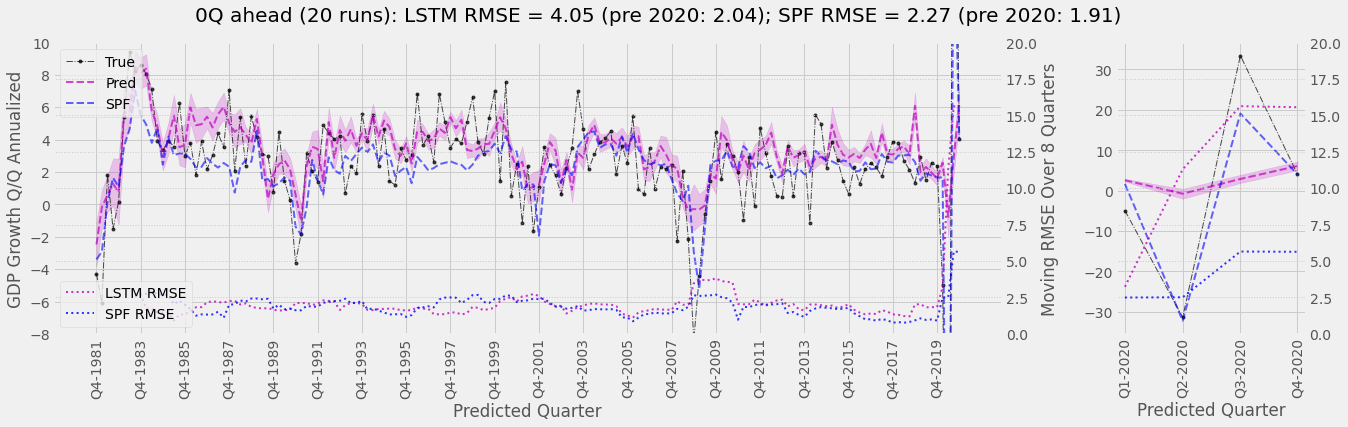

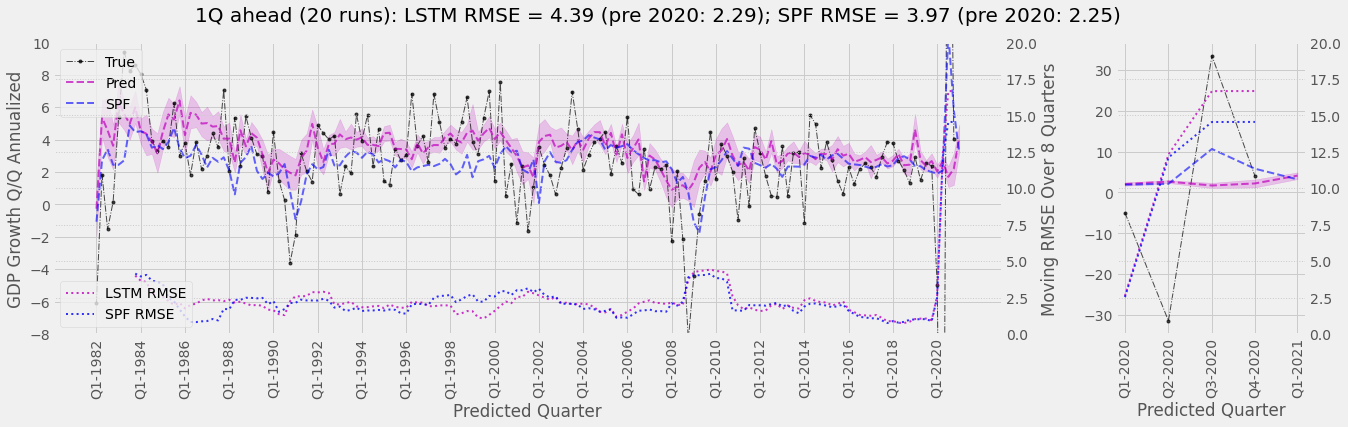

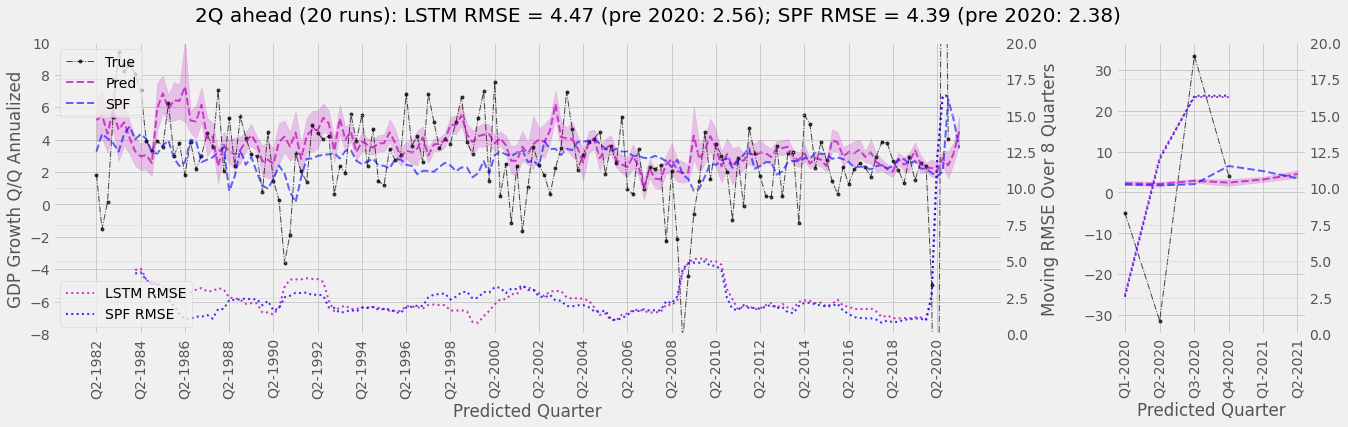

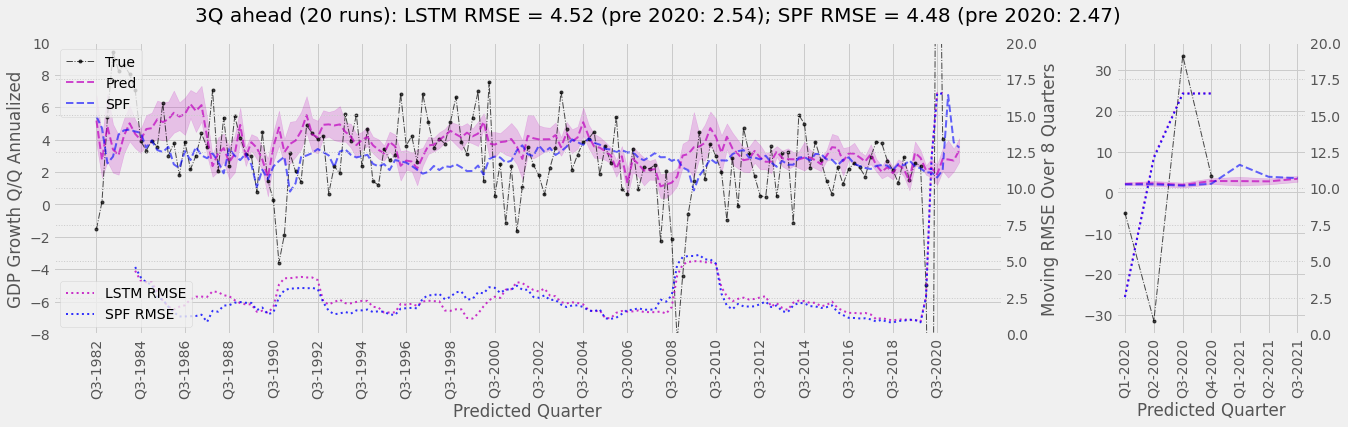

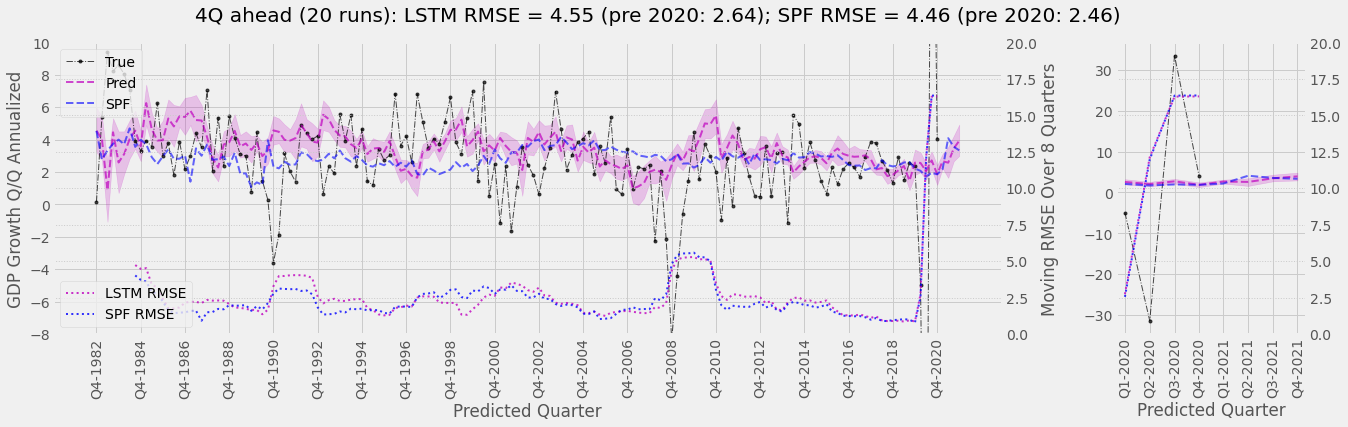

In [109]:
for q in range(target_size):
  plot_pred(q)

In [110]:
# for q in range(target_size):
#   plot_pred(q)

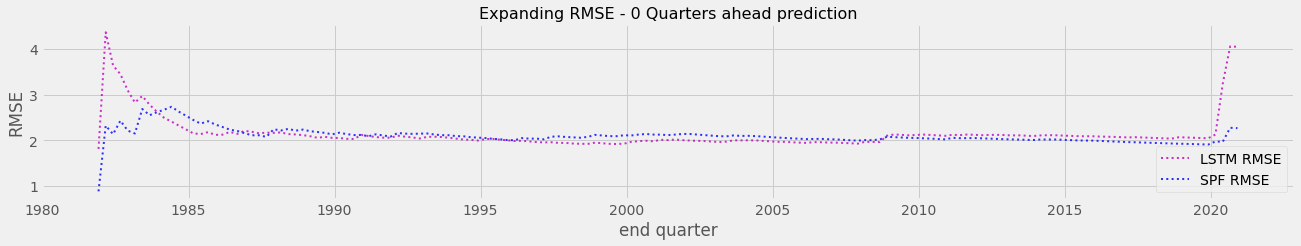

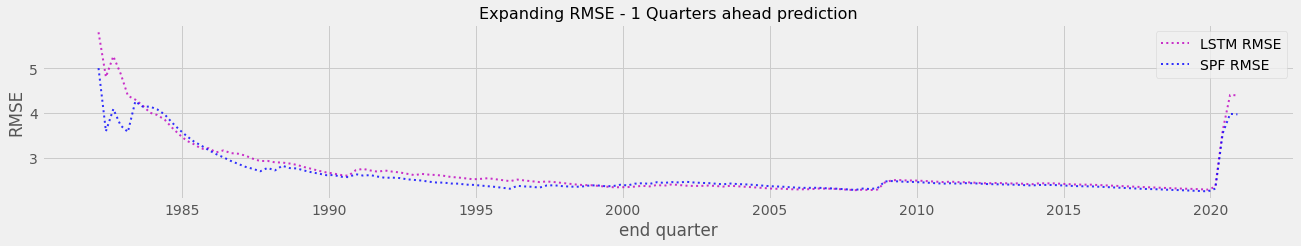

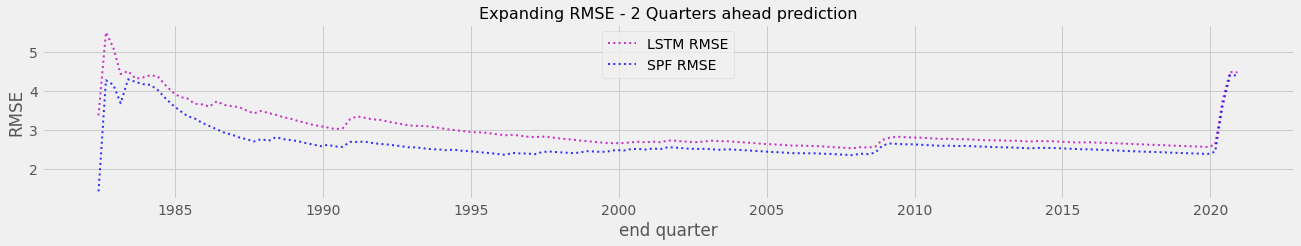

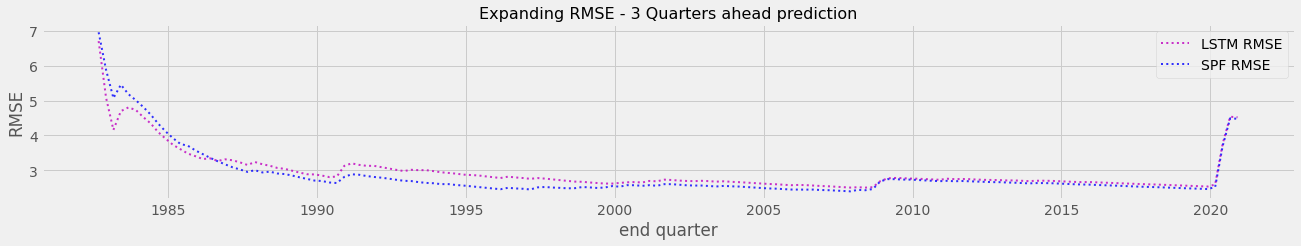

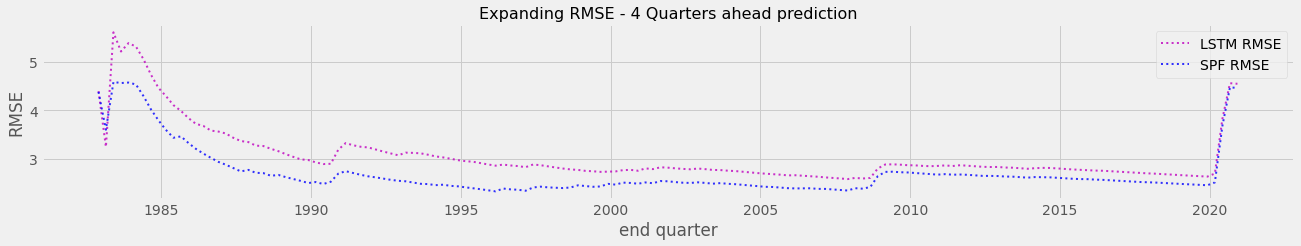

In [111]:
def plot_exp_rmse(q):

    plt.figure(figsize=(20,3))
    df = val_qm_pred_summary[q].copy()
    df.index.names = ['predicted_quarter']
    df.reset_index(inplace=True)

    df_joined = df[['predicted_quarter', 'ave_pred',  'true']].set_index('predicted_quarter')
    df_joined = df_joined.join(df_spf.iloc[:,q], how='left')
    df_joined.columns = ['ave_pred', 'true', 'SPF']

    exp_model_rmse = []
    exp_spf_rmse = []
    #Q = moving_rmse_n_Qs
    for j in range(1, df_joined.shape[0]+1):
        exp_model_rmse.append(sqrt(keras.metrics.mean_squared_error(df_joined['true'][:j], df_joined['ave_pred'][:j])))
        exp_spf_rmse.append(sqrt(keras.metrics.mean_squared_error(df_joined['true'][:j], df_joined['SPF'][:j])))
    expanding_rmse = pd.DataFrame({'date':df_joined.index, 'model_rmse':exp_model_rmse ,'SPF_rmse': exp_spf_rmse}).set_index('date')
    
    plt.plot(expanding_rmse['model_rmse'], label='LSTM RMSE', color='m', linestyle=':', linewidth=2, alpha=0.8)
    plt.plot(expanding_rmse['SPF_rmse'], label='SPF RMSE', color='b', linestyle=':', linewidth=2, alpha=0.8)
    plt.xlabel('end quarter')
    plt.ylabel('RMSE')
    plt.title('Expanding RMSE - {q} Quarters ahead prediction'.format(q=q), size=16)
    plt.legend()
    plt.show();

for q in range(target_size):
    plot_exp_rmse(q)

In [112]:
from IPython.core.display import display, HTML
display(HTML('<div style="width: 640px; height: 480px; margin: 10px; position: relative;"><iframe allowfullscreen frameborder="0" style="width:640px; height:480px" src="https://lucid.app/documents/embeddedchart/486da044-af6c-4fd8-96c5-2d60852a43de" id="bdk9o74HXvA0"></iframe></div>'))